In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from deeper.csv2dataset import get_cosine,text_to_vector
from deeper.DeepER import init_embeddings_index, init_embeddings_model, init_DeepER_model
from deeper.data import data2Inputs
from deeper.data import process_data_aligned
from keras.models import load_model

Using TensorFlow backend.


In [12]:
import ast 
df = pd.read_csv('rankings/beer_flippedneg_deepmatcher.csv')
df['alteredAttributes'] = df['alteredAttributes'].apply(ast.literal_eval)
df.iloc[0].alteredAttributes

('Style',)

## Experiment with triangles

In [6]:
def getMatchesMinCosSim(df,lprefix,rprefix,ignore_columns=['id','label']):
    cos_sim_list = []
    lattributes = [attr for attr in df.columns if(attr not in ignore_columns and attr.startswith(lprefix))]
    rattributes = [attr for attr in df.columns if(attr not in ignore_columns and attr.startswith(rprefix))]
    for i in range(len(df.index)):
        if df.iloc[i]['label']=='1':
            row = df.iloc[i]
            lrecord = " ".join(list(map(lambda attr:row[attr],lattributes)))
            rrecord = " ".join(list(map(lambda attr:row[attr],rattributes)))
            cos_sim_list.append(get_cosine(text_to_vector(lrecord),text_to_vector(rrecord)))
    return min(cos_sim_list)

In [7]:
train_walmart = pd.read_csv('datasets/walmart_amazon/train.csv',dtype=str).fillna("")
getMatchesMinCosSim(train_walmart,'ltable_','rtable_')

0.11669000700233413

In [6]:
train_fodors = pd.read_csv('datasets/fodors_zagats/train.csv',dtype=str).fillna("")
getMatchesMinCosSim(train_fodors,'ltable_','rtable_')

0.5669467095138409

In [10]:
walmart = pd.read_csv('datasets/walmart_amazon/walmart.csv',dtype=str)
amazon = pd.read_csv('datasets/walmart_amazon/amazon.csv',dtype=str)
triangles = getMixedTriangles(train_walmart,[walmart,amazon])
len(triangles)

0

In [3]:
from explanation.sampleBuilder import prepareDataset
augmented_train = prepareDataset('datasets/walmart_amazon/','train.csv','walmart.csv','amazon.csv',
                                100)

100%|██████████| 758/758 [01:56<00:00,  6.53it/s]


In [8]:
len(train_walmart),len(augmented_train)

(1476, 2017)

In [34]:
triangles = getMixedTriangles(augmented_train,[walmart,amazon])

In [35]:
triangles[0]

(id                                                        13477
 brand                                                      Sony
 modelno                                                DPW30R2H
 title          Sony Dpw30R2H 1.4 Gb Camcorder 8Cm Dvd Rw Single
 price                                                      3.49
 dimensions                               3.9 x 3.5 x 0.3 inches
 imageurl      http://ecx.images-amazon.com/images/I/51SDD1DW...
 shipweight                                             1 pounds
 Name: 13476, dtype: object,
 id                                                         2354
 brand                                                      Sony
 modelno                                                DPW30R2H
 title                  Sony DPW30R2H 1.4GB Camcorder 8cm DVD RW
 price                                                      8.88
 dimensions                              4.0 x 3.6 x 0.25 inches
 imageurl      http://i.walmartimages.com/i/p/00/02/72/42/66/

In [43]:
def testTriangles(dataset,triangles):
    dataset_c = dataset.copy()
    dataset_c['ltable_id'] = list(map(lambda lrid:lrid.split("#")[0],dataset_c.id.values))
    dataset_c['rtable_id'] = list(map(lambda lrid:lrid.split("#")[1],dataset_c.id.values))
    positives = dataset_c[dataset_c.label=='1']
    negatives = dataset_c[dataset_c.label=='0']
    for triangle in triangles:
        provenance = triangle[3].split('-')
        if provenance[0]=='R' and provenance[1]=='L':
            pair1 = triangle[1]['id']+"#"+triangle[0]['id']
            pair2 = triangle[1]['id']+"#"+triangle[2]['id']
        else:
            pair1 = triangle[0]['id']+"#"+triangle[1]['id']
            pair2 = triangle[2]['id']+"#"+triangle[1]['id']
        if not(pair1 in positives.id.values and pair2 in negatives.id.values):
            print(pair1)
            print(pair2)

In [46]:
augmented_train[augmented_train.id=='2354#167']

,label,ltable_brand,ltable_modelno,ltable_title,ltable_price,ltable_dimensions,ltable_imageurl,ltable_shipweight,rtable_brand,rtable_modelno,rtable_title,rtable_price,rtable_dimensions,rtable_imageurl,rtable_shipweight,id
0,1,Sony,DPW30R2H,Sony DPW30R2H 1.4GB Camcorder 8cm DVD RW,8.88,4.0 x 3.6 x 0.25 inches,http://i.walmartimages.com/i/p/00/02/72/42/66/...,0.18,Sony,DPW30R2H,Sony Dpw30R2H 1.4 Gb Camcorder 8Cm Dvd Rw Single,3.49,3.9 x 3.5 x 0.3 inches,http://ecx.images-amazon.com/images/I/51SDD1DW...,1 pounds,2354#13477


In [31]:
test_fodors = pd.read_csv('datasets/fodors_zagats/augmented_test.csv')
fodors = pd.read_csv('datasets/fodors_zagats/fodors.csv',dtype=str)
zagats = pd.read_csv('datasets/fodors_zagats/zagats.csv',dtype=str)
triangles_fodors = getMixedTriangles(test_fodors,[fodors,zagats])
testTriangles(test_fodors,triangles_fodors)

## Compare black and white model

In [4]:
itunes_model = dm.MatchingModel(attr_summarizer='hybrid')
itunes_model.load_state('models/itunes_amazon_hybrid.pth')
itunes = pd.read_csv('datasets/itunes_amazon/itunes.csv')

In [6]:
itunes_model = itunes_model.to('cuda')
explainer_itunes = Explainer(itunes_model,[attr for attr in itunes.columns if attr not in ['id']])

In [8]:
negranking,negri,testneg = explainer_itunes.getRankingsWhiteBox('datasets/itunes_amazon/','augmented_test',
                                                       0,'cosine')

Computing vectors in the classifier space


  0%|          | 0/90 [00:00<?, ?it/s]

112
4


100%|██████████| 90/90 [00:44<00:00,  2.01it/s]


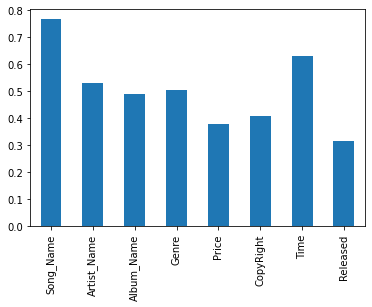

In [10]:
negri.drop(['sample_id'],axis=1).mean().plot.bar()

In [11]:
posranking,posri,testpos = explainer_itunes.getRankingsWhiteBox('datasets/itunes_amazon/','augmented_test',
                                                       1,'cosine')

Computing vectors in the classifier space


  0%|          | 0/22 [00:00<?, ?it/s]

112
4


100%|██████████| 22/22 [00:08<00:00,  2.58it/s]


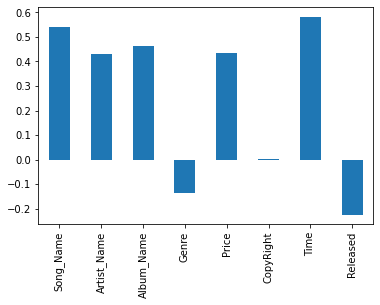

In [12]:
posri.drop(['sample_id'],axis=1).mean().plot.bar()

In [13]:
walmart_model = dm.MatchingModel(attr_summarizer='hybrid')
walmart_model.load_state('models/walmart_amazon_hybrid.pth')
walmart_model = walmart_model.to('cuda')

In [16]:
walmart = pd.read_csv('datasets/walmart_amazon/walmart.csv')
walmart_explainer = Explainer(walmart_model,[attr for attr in walmart.columns if attr not in ['id']])

In [17]:
negranking,negri,testneg = walmart_explainer.getRankingsWhiteBox('datasets/walmart_amazon/','augmented_test',
                                                       0,'cosine')

Computing vectors in the classifier space


  0%|          | 0/619 [00:00<?, ?it/s]

838
27


100%|██████████| 619/619 [05:55<00:00,  1.74it/s]


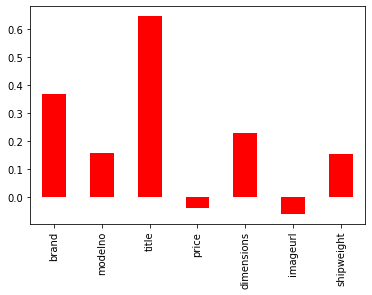

In [18]:
negri.drop(['sample_id'],axis=1).mean().plot.bar(color='red')

In [19]:
posranking,posri,testpos = walmart_explainer.getRankingsWhiteBox('datasets/walmart_amazon/','augmented_test',
                                                       1,'cosine')

Computing vectors in the classifier space


  0%|          | 0/219 [00:00<?, ?it/s]

838
27


100%|██████████| 219/219 [02:05<00:00,  1.74it/s]


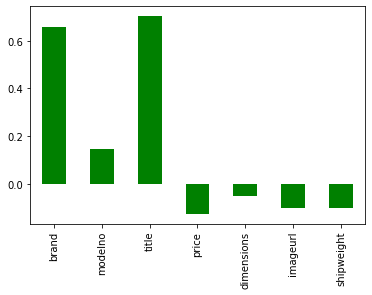

In [20]:
posri.drop(['sample_id'],axis=1).mean().plot.bar(color='green')

In [21]:
beer_model = dm.MatchingModel(attr_summarizer='hybrid')
beer_model.load_state('models/beeradvo_ratebeer_hybrid.pth')
beeradvo = pd.read_csv('datasets/beeradvo_ratebeer/Beeradvo.csv')
beer_model = beer_model.to('cuda')

In [22]:
beer_explainer = Explainer(beer_model,[attr for attr in beeradvo.columns if attr not in ['id']])

In [23]:
negranking,negri,testneg = beer_explainer.getRankingsWhiteBox('datasets/beeradvo_ratebeer/','augmented_test',
                                                       0,'cosine')

Computing vectors in the classifier space


  0%|          | 0/55 [00:00<?, ?it/s]

74
3


100%|██████████| 55/55 [00:09<00:00,  5.51it/s]


In [24]:
posrank,posri,testpos = beer_explainer.getRankingsWhiteBox('datasets/beeradvo_ratebeer/','augmented_test',
                                                          1,'cosine')

Computing vectors in the classifier space


  0%|          | 0/19 [00:00<?, ?it/s]

74
3


100%|██████████| 19/19 [00:02<00:00,  6.78it/s]


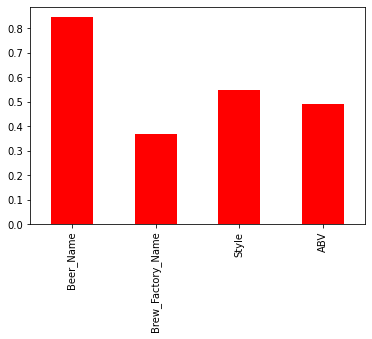

In [26]:
negri.drop(['sample_id'],axis=1).mean().plot.bar(color='red')

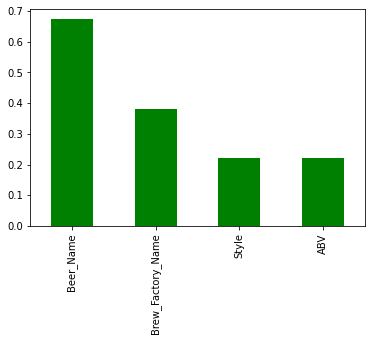

In [27]:
posri.drop(['sample_id'],axis=1).mean().plot.bar(color='green')

In [28]:
dblpacm_model = dm.MatchingModel(attr_summarizer='hybrid')
dblpacm_model.load_state('models/dblp_acm_hybrid.pth')
dblpacm_model = dblpacm_model.to('cuda')

In [31]:
dblp = pd.read_csv('datasets/DBLP-ACM/DBLP2.csv')
dblpacm_explainer = Explainer(dblpacm_model,[attr for attr in dblp.columns if attr not in ['id']])

In [33]:
negranking,negri,testneg = dblpacm_explainer.getRankingsWhiteBox('datasets/DBLP-ACM/','augmented_test',
                                                       0,'cosine')

Computing vectors in the classifier space


  0%|          | 0/760 [00:00<?, ?it/s]

1186
38


100%|██████████| 760/760 [03:52<00:00,  3.27it/s]


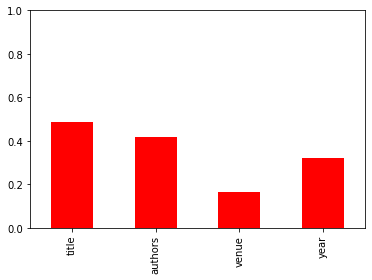

In [35]:
negri.drop(['sample_id'],axis=1).mean().plot.bar(color='red',ylim=(0,1))

In [36]:
posranking,posri,testpos = dblpacm_explainer.getRankingsWhiteBox('datasets/DBLP-ACM/','augmented_test',
                                                       1,'cosine')

Computing vectors in the classifier space


  0%|          | 0/426 [00:00<?, ?it/s]

1186
38


100%|██████████| 426/426 [01:24<00:00,  5.05it/s]


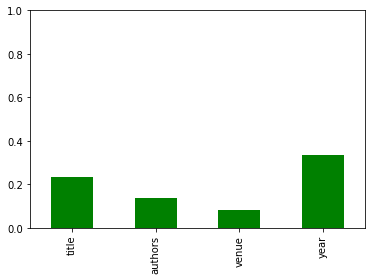

In [37]:
posri.drop(['sample_id'],axis=1).mean().plot.bar(color='green',ylim=(0,1))

## Test groups of attributes

In [11]:
from explanation.deepmatcher_utils import wrapDm

In [12]:
predict_fn_deepmatcher = lambda data,model,ignore: wrapDm(data,model,ignore_columns=ignore)

In [ ]:
#to filter most important set of attributes
def filterRankings(rankings,threshold):
    for attrset,importance in rankings:
        

### Beer

In [58]:
augmented_test = pd.read_csv('datasets/beeradvo_ratebeer/augmented_test.csv')
beeradvo = pd.read_csv('datasets/beeradvo_ratebeer/Beeradvo.csv',dtype=str)
ratebeer = pd.read_csv('datasets/beeradvo_ratebeer/Ratebeer.csv',dtype=str)

In [59]:
beer_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
beer_deepmatcher.load_state('models/beeradvo_ratebeer_rnn.pth')

In [60]:
negrank_beer,_ = explainSamples(augmented_test,[beeradvo,ratebeer],beer_deepmatcher,predict_fn_deepmatcher,
                                 0,maxLenAttributeSet=3)

100%|██████████| 30/30 [00:03<00:00,  8.94it/s]


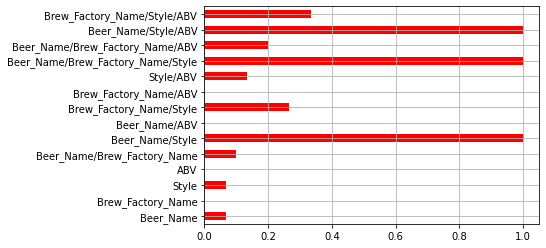

In [61]:
beer_ax = negrank_deeper.plot.barh(color='red',grid=True)

In [62]:
figure = beer_ax.get_figure()
figure.savefig('negrank_beer.png',dpi=300,bbox_inches='tight')

### Walmart-Amazon

In [29]:
augmented_test = pd.read_csv('datasets/walmart_amazon/augmented_test.csv')
walmart = pd.read_csv('datasets/walmart_amazon/walmart.csv',dtype=str)
amazon = pd.read_csv('datasets/walmart_amazon/amazon.csv',dtype=str)

In [30]:
walmart_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
walmart_deepmatcher.load_state('models/walmart_amazon_rnn.pth')

In [31]:
negrank_deepmatcher,_ = explainSamples(augmented_test,[walmart,amazon],walmart_deepmatcher,
                             predict_fn_deepmatcher,0,maxLenAttributeSet=4)

100%|██████████| 548/548 [07:41<00:00,  1.19it/s]


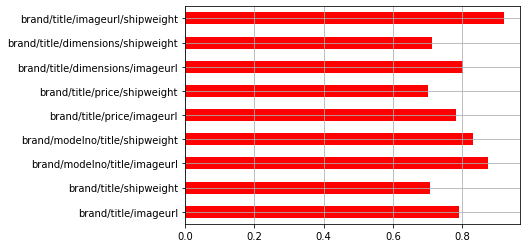

In [45]:
negrank_deepmatcher_filtered = negrank_deepmatcher[negrank_deepmatcher>0.7]
ax_walmart = negrank_deepmatcher_filtered.plot.barh(color='red',grid=True)
fig = ax_walmart.get_figure()
fig.savefig('negrank_walmart.png',dpi=300,bbox_inches='tight')

### DBLP-ACM

In [46]:
augmented_test = pd.read_csv('datasets/DBLP-ACM/augmented_test.csv')
dblp = pd.read_csv('datasets/DBLP-ACM/DBLP2.csv',dtype=str)
acm = pd.read_csv('datasets/DBLP-ACM/ACM.csv',dtype=str)

In [47]:
dblpacm_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
dblpacm_deepmatcher.load_state('models/dblp_acm_rnn.pth')

In [48]:
negrank_dblpacm,_ = explainSamples(augmented_test,[dblp,acm],dblpacm_deepmatcher,predict_fn_deepmatcher,
                                        0,maxLenAttributeSet=3)

100%|██████████| 629/629 [02:34<00:00,  4.07it/s]


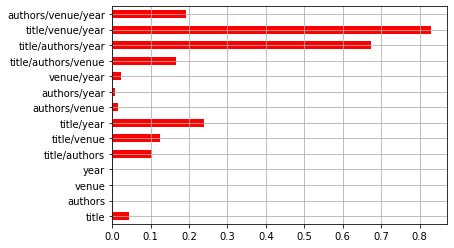

In [49]:
ax_dblpacm = negrank_dblpacm.plot.barh(color='red',grid=True)
fig = ax_dblpacm.get_figure()
fig.savefig('negrank_dblpacm.png',dpi=300,bbox_inches='tight')

### Itunes-Amazon

In [51]:
DATASET_DIR = 'datasets/itunes_amazon/'
augmented_test = pd.read_csv(DATASET_DIR+'augmented_test.csv')
itunes = pd.read_csv(DATASET_DIR+'itunes.csv',dtype=str)
amazon = pd.read_csv(DATASET_DIR+'amazon.csv',dtype=str)

In [52]:
itunes_deepmatcher = dm.MatchingModel(attr_summarizer='rnn')
itunes_deepmatcher.load_state('models/itunes_amazon_rnn.pth')

In [53]:
negrank_itunes,_ = explainSamples(augmented_test,[itunes,amazon],itunes_deepmatcher,
                                         predict_fn_deepmatcher,0,maxLenAttributeSet=4)

100%|██████████| 76/76 [01:31<00:00,  1.21s/it]


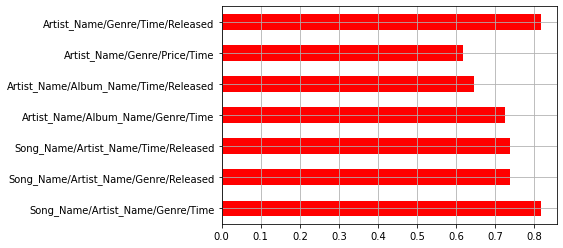

In [57]:
negrank_itunes_filt = negrank_itunes[negrank_itunes>=0.6]
ax_itunes = negrank_itunes_filt.plot.barh(color='red',grid=True)
fig = ax_itunes.get_figure()
fig.savefig('negrank_itunes_amazon.png',dpi=300,bbox_inches='tight')

## Test vanilla gradient

In [3]:
DATASET_DIR = 'datasets/walmart_amazon/'
DATASET_NAME = 'walmart_amazon'
deeper_train,deeper_test = process_data_aligned(DATASET_DIR,DATASET_NAME,ground_truth='walmart-amazon_perfectMapping.csv',
                         table1='walmart.csv',table2='amazon.csv',load_from_disk_dataset=True)

match_number: 1154
len all dataset: 2308


In [11]:
# Caricamento strutture dati e modelli ausiliari.
EMBEDDING_FILEPATH ='embeddings/glove.840B.300d.txt'
embeddings_model, tokenizer = init_embeddings_model(EMBEDDING_FILEPATH,deeper_train,deeper_test)

* Costruzione indice degli embeddings.....Fatto. 2196016 embeddings totali.
* Inizializzo il tokenizzatore.....Fatto: 12650 parole totali.
* Preparazione della matrice di embedding.....Fatto. Dimensioni matrice embeddings: (12651, 300)

°°° EMBEDDING MODEL °°°
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tupla_A (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Tupla_B (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Embedding_lookup (Embedding)    (None, None, 300)    3795300     Tupla_A[0][0]                    
                             

In [12]:
from deeper.DeepER import init_DeepER_model,train_model_ER
deeper_model = init_DeepER_model(300)
dataset_name='walmart-amazon'
deeper_model = train_model_ER(deeper_train,deeper_model, 
                                      embeddings_model, 
                                      tokenizer, 
                                      pretraining=False,
                                      metric='val_accuracy',
                                      end=f'_{int(1*100)}_{dataset_name}')


°°° DeepER Model °°°
Batch size: 29
Train on 1476 samples, validate on 370 samples
Epoch 1/64
1476/1476 [==============================] - 6s 4ms/step - loss: 0.3304 - accuracy: 0.8299 - val_loss: 0.1124 - val_accuracy: 0.9568

Epoch 00001: val_accuracy improved from -inf to 0.95676, saving model to models/DeepER_best_model_100_walmart-amazon.h5
Epoch 2/64
1476/1476 [==============================] - 4s 2ms/step - loss: 0.0855 - accuracy: 0.9756 - val_loss: 0.0958 - val_accuracy: 0.9649

Epoch 00002: val_accuracy improved from 0.95676 to 0.96486, saving model to models/DeepER_best_model_100_walmart-amazon.h5
Epoch 3/64
1476/1476 [==============================] - 4s 2ms/step - loss: 0.0191 - accuracy: 0.9986 - val_loss: 0.0638 - val_accuracy: 0.9811

Epoch 00003: val_accuracy improved from 0.96486 to 0.98108, saving model to models/DeepER_best_model_100_walmart-amazon.h5
Epoch 4/64
1476/1476 [==============================] - 4s 3ms/step - loss: 0.0088 - accuracy: 0.9980 - val_loss: 0

In [7]:
walmart_model = load_model('models/DeepER_best_model_100_walmart-amazon.h5')

In [13]:
ltable,rtable,labels = data2Inputs(deeper_train,tokenizer)
lembeddings,rembeddings = embeddings_model.predict([ltable,rtable])

In [14]:
import tensorflow as tf
import numpy as np

In [16]:
x = tf.Variable(3.0, trainable=True)
with tf.GradientTape() as tape:
    y = x**3

grad = tape.gradient(y, x)
print(type(grad))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [17]:
deeper_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Embeddings_seq_a (InputLayer)   (None, None, 300)    0                                            
__________________________________________________________________________________________________
Embeddings_seq_b (InputLayer)   (None, None, 300)    0                                            
__________________________________________________________________________________________________
Composition (Bidirectional)     (None, 300)          541200      Embeddings_seq_a[0][0]           
                                                                 Embeddings_seq_b[0][0]           
__________________________________________________________________________________________________
Similarity (Lambda)             (None, 300)          0           Composition[0][0]          

In [122]:
def _input_fn(seq1,seq2,labels):
    def generator():
        for s1, s2, l in zip(seq1,seq2,labels):
            yield {"seq_a": s1, "seq_b": s2}, l
    dataset = tf.data.Dataset.from_generator(generator,output_types=({"seq_a": tf.float32, "seq_b": tf.float32}, 
                                                                     tf.float32))
    dataset = dataset.batch(2)
    return dataset

In [123]:
dataset = _input_fn(lembeddings,rembeddings,labels)

In [18]:
lembeddings = tf.Variable(lembeddings[0:10])
rembeddings = tf.Variable(rembeddings[0:10])
with tf.GradientTape() as tape:
    prediction = deeper_model([lembeddings,rembeddings])

In [29]:
prediction.eval()

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [22]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**x

print(tape.gradient(y, x).numpy()) # -> 27.0

56.662533


In [23]:
preds

<tf.Tensor 'model_2_1/Classification/Softmax:0' shape=(10, 2) dtype=float32>

In [106]:
walmart_model.input[0] = K.variable(value=l_exampleInput)
walmart_model.input[1] = K.variable(value=r_exampleInput)
true_labels_tf = K.variable(value=labels[:10])
loss = K.binary_crossentropy(true_labels_tf,walmart_model.output)
grads = K.gradients(loss,walmart_model.input)

In [110]:
tf_session.run(grads,{walmart_model.input[0]:l_exampleInput,walmart_model.input[1]:r_exampleInput})

TypeError: Variable is unhashable. Instead, use tensor.ref() as the key.

In [111]:
print("Eager mode: ", tf.executing_eagerly())

Eager mode:  True


In [2]:
import pandas as pd
import csv
glove_data_file = 'embeddings/glove.840B.300d.txt'
words = pd.read_table(glove_data_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

In [11]:
words.index

Index([             ',',              '.',            'the',            'and',
                   'to',             'of',              'a',             'in',
                    '"',              ':',
       ...
            'work.Like',     'working.So',          'wried',          'wwent',
              'xalisae', 'xtremecaffeine',       'yildirim',           'z/28',
               'zipout',      'zulchzulu'],
      dtype='object', name=0, length=2196017)

In [6]:
def vec(w):
    return words.loc[w].values

In [8]:
vec('consitution')

array([-9.7177e-02, -3.3384e-02,  3.5014e-01, -1.8332e-01,  1.3991e-01,
        1.4037e-01,  1.5549e-01,  2.6000e-01, -1.6789e-01, -7.5411e-01,
        3.5749e-01, -4.6657e-02, -7.3601e-01,  2.6569e-01, -3.9213e-01,
       -1.8553e-01,  9.4739e-02, -1.3162e+00,  5.8292e-01,  1.4264e-01,
        3.0429e-01,  2.6872e-01,  9.3631e-01,  4.8064e-01, -4.0287e-01,
        3.3929e-01, -5.4562e-01, -3.7431e-01, -5.0206e-01,  1.1783e-01,
       -1.2869e-01,  3.6222e-01,  5.9760e-01, -3.0900e-01, -5.8794e-02,
       -4.6398e-02,  8.7882e-03, -6.3006e-01, -2.5602e-01,  1.9828e-01,
       -1.4751e-01,  1.7908e-01, -3.4638e-01, -1.0368e-01, -5.7839e-01,
       -1.1368e-01,  3.6085e-01, -3.6652e-01,  1.9954e-01,  4.2497e-02,
       -2.6382e-01,  3.7090e-01, -3.2299e-02,  3.6971e-01, -1.1806e-01,
       -3.0572e-01,  8.1367e-02,  8.9751e-02,  3.9723e-01, -3.8662e-01,
        1.9195e-01,  1.5399e-01, -1.9541e-01,  4.7187e-02, -1.7594e-01,
        4.9402e-01, -5.8037e-01,  2.5909e-01, -5.0218e-02, -1.85

## Create datasets

In [12]:
import pandas as pd
import codecs
import numpy as np

In [2]:
train = pd.read_csv('datasets/beeradvo_ratebeer/train.csv')
test = pd.read_csv('datasets/beeradvo_ratebeer/test.csv')
validation = pd.read_csv('datasets/beeradvo_ratebeer/validation.csv')

In [3]:
allsamples = pd.concat([train,validation,test],ignore_index=True)
allsamples.to_csv('datasets/beeradvo_ratebeer/beer_dataset.csv',index=True)

In [10]:
def load_embeddings(embeddings_path):
    with codecs.open(embeddings_path + '.vocab', 'r', 'utf-8') as f_in:
        index2word = [line.strip() for line in f_in]
    word2index = {w: i for i, w in enumerate(index2word)}
    wv = np.load(embeddings_path + '.npy')
    
    return wv, index2word, word2index

In [13]:
wv,index2word,word2index = load_embeddings('embeddings/glove.840B.300d')

In [14]:
word2index['UNK']

132034

In [8]:
def getVector(word,word2index,wv):
    return wv[word2index[word]]

In [11]:
v1 = getVector('amphibian',word2index,wv)
v2 = getVector('frog',word2index,wv)
v3 = getVector('toad',word2index,wv)

In [11]:
import scipy.spatial.distance as dist

In [12]:
dist.cosine(v1,v2)

0.4241259005679586

In [4]:
l1 = [1,2,3]
l2 = [4,5,5]
l3 = np.array([l1,l2])
l3.shape

(2, 3)

In [5]:
l3

array([[1, 2, 3],
       [4, 5, 5]])

In [21]:
from deeper.DeepER import init_embeddings_model

In [32]:
embedding_model,tokenizer = init_embeddings_model('embeddings/glove.840B.300d')

* Inizializzo il tokenizzatore.....Fatto: 1131709 parole totali.
* Preparazione della matrice di embedding.....Fatto. Dimensioni matrice embeddings: (1131710, 300)

°°° EMBEDDING MODEL °°°
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tupla_A (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Tupla_B (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
Embedding_lookup (Embedding)    (None, None, 300)    339513000   Tupla_A[0][0]                    
                                                                 Tupla_B[0][0]                    
To

In [29]:
from deeper.Dataset import Dataset
from deeper.data import process_data_aligned

In [31]:
train,test = process_data_aligned('datasets/walmart_amazon/','walmart-amazon',
                                  'walmart-amazon_perfectMapping.csv',
                                  'walmart.csv','amazon.csv',load_from_disk_dataset=True)

match_number: 1154
len all dataset: 2308


In [35]:
train_deeper = Dataset(tokenizer,embedding_model,train)

In [38]:
train_deeper.data['left_records'].shape

(1846, 56, 300)

In [39]:
test_deeper = Dataset(tokenizer,embedding_model,train)

In [40]:
test_deeper.data['right_records'].shape

(1846, 68, 300)

In [42]:
train,test = process_data_aligned('datasets/DBLP-ACM/','dblp-acm',
                                  'DBLP-ACM_perfectMapping.csv',
                                  'DBLP2.csv','ACM.csv',load_from_disk_dataset=True)

match_number: 2224
len all dataset: 4448


In [45]:
test_dblp = Dataset(tokenizer,embedding_model,test,unlabeled=False)

In [44]:
test_un

[(['Lifestreams: A Storage Model for Personal Data',
   'Eric Freeman, David Gelernter',
   'SIGMOD Record',
   '1996'],
  ['Lifestreams: a storage model for personal data',
   'Eric Freeman, David Gelernter',
   'ACM SIGMOD Record ',
   '1996'],
  1,
  'journals/sigmod/FreemanG96#381893'),
 (['The PointCast Network',
   'Vibha Dayal, Satish Ramakrishnan',
   'SIGMOD Conference',
   '1998'],
  ['Repositories and object oriented databases',
   'Philip A. Bernstein',
   'ACM SIGMOD Record ',
   '1998'],
  0,
  'conf/sigmod/RamakrishnanD98#273271'),
 (['Push Technology Personalization through Event Correlation',
   'Asaf Adi, David Botzer, Tali Yatzkar-Haham, Opher Etzion',
   'VLDB',
   '2000'],
  ['Push Technology Personalization through Event Correlation',
   'Asaf Adi, David Botzer, Opher Etzion, Tali Yatzkar-Haham',
   'Very Large Data Bases',
   '2000'],
  1,
  'conf/vldb/AdiBEY00#671839'),
 (['Finding Generalized Projected Clusters In High Dimensional Spaces',
   'Charu C. Aggarwal